<a href="https://colab.research.google.com/github/cdwangco/SentimentAnalysisProject/blob/main/MLProjectYTSentimentAnalysis2ndDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

In [4]:
#input data source here
# df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None
# !unzip comments.csv.zip


In [5]:
df = pd.read_csv('comments.csv')

In [6]:
print(df.head())
df = df[:2000]
print(df['Sentiment'].value_counts()) #we have a balanced data set


   Unnamed: 0     Video ID                                            Comment  \
0           0  wAZZ-UWGVHI  Let's not forget that Apple Pay in 2014 requir...   
1           1  wAZZ-UWGVHI  Here in NZ 50% of retailers don’t even have co...   
2           2  wAZZ-UWGVHI  I will forever acknowledge this channel with t...   
3           3  wAZZ-UWGVHI  Whenever I go to a place that doesn’t take App...   
4           4  wAZZ-UWGVHI  Apple Pay is so convenient, secure, and easy t...   

   Likes  Sentiment  
0   95.0        1.0  
1   19.0        0.0  
2  161.0        2.0  
3    8.0        0.0  
4   34.0        2.0  
2.0    1096
1.0     556
0.0     348
Name: Sentiment, dtype: int64


In [7]:
df = df.iloc[:,[2,4]]

In [8]:
df['1'] = df['Sentiment'].apply(lambda x: 0 if x <= 1 else 1)
df = df.iloc[:,[0,2]]
df

,Comment,1
0,Let's not forget that Apple Pay in 2014 requir...,0
1,Here in NZ 50% of retailers don’t even have co...,0
2,I will forever acknowledge this channel with t...,1
3,Whenever I go to a place that doesn’t take App...,0
4,"Apple Pay is so convenient, secure, and easy t...",1
...,...,...
1995,Hii cookie I love your videos soo much! 🍪,1
1996,Hii cookie! Can you post a video that show us ...,1
1997,Hey cookie cutter! Looking handsome as always ❤️,1
1998,I tried it and it not changing I’m still on 30...,0


In [9]:
df = df.rename(columns={'Comment': 0})
df


,0,1
0,Let's not forget that Apple Pay in 2014 requir...,0
1,Here in NZ 50% of retailers don’t even have co...,0
2,I will forever acknowledge this channel with t...,1
3,Whenever I go to a place that doesn’t take App...,0
4,"Apple Pay is so convenient, secure, and easy t...",1
...,...,...
1995,Hii cookie I love your videos soo much! 🍪,1
1996,Hii cookie! Can you post a video that show us ...,1
1997,Hey cookie cutter! Looking handsome as always ❤️,1
1998,I tried it and it not changing I’m still on 30...,0


In [10]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getVader(text):
  score = analyzer.polarity_scores(text)
  return 1 if score['compound'] >= 0 else 0


In [12]:
df['Vader'] = df[0].apply(getVader)
df.head()

,0,1,Vader
0,Let's not forget that Apple Pay in 2014 requir...,0,1
1,Here in NZ 50% of retailers don’t even have co...,0,1
2,I will forever acknowledge this channel with t...,1,1
3,Whenever I go to a place that doesn’t take App...,0,0
4,"Apple Pay is so convenient, secure, and easy t...",1,1


In [13]:
!pip install flair

  Using cached importlib_metadata-3.10.1-py3-none-any.whl (14 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.12.0
    Uninstalling importlib-metadata-4.12.0:
      Successfully uninstalled importlib-metadata-4.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [14]:
from scipy.stats.stats import RanksumsResult
# Evaluate the test using Flair baseline
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')




2022-12-02 11:14:06.160300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-02 11:14:14,005 loading file /Users/josegarza/.flair/models/sentiment-en-mix-distillbert_4.pt


In [15]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    # if value == 'POSITIVE':
    #     result = text.to_dict()['labels'][0]['confidence']
    # else:
    #     result = -(text.to_dict()['labels'][0]['confidence'])
    # return round(result, 3)
    return 1 if value == 'POSITIVE' else 0

def flairPredict(sentence):
  # print(text)
  result = predict(sentence)
  return result

In [16]:

df['FlairScore'] = df[0].apply(flairPredict)
df.head()
print(len(df))

2000


In [17]:
df

,0,1,Vader,FlairScore
0,Let's not forget that Apple Pay in 2014 requir...,0,1,0
1,Here in NZ 50% of retailers don’t even have co...,0,1,0
2,I will forever acknowledge this channel with t...,1,1,1
3,Whenever I go to a place that doesn’t take App...,0,0,0
4,"Apple Pay is so convenient, secure, and easy t...",1,1,1
...,...,...,...,...
1995,Hii cookie I love your videos soo much! 🍪,1,1,1
1996,Hii cookie! Can you post a video that show us ...,1,1,1
1997,Hey cookie cutter! Looking handsome as always ❤️,1,1,1
1998,I tried it and it not changing I’m still on 30...,0,1,0


In [18]:
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score


In [19]:
def getSubj(text):
  return TextBlob(text).sentiment.subjectivity

def getPol(text):
  return TextBlob(text).sentiment.polarity

def binarize(float):
  return 1 if float > 0 else 0
  


In [20]:

data = df.rename(columns={0: 'Comment', '1':'Label'})
data['Polarity'] = data['Comment'].apply(getPol)
data['TextBlob'] = data['Polarity'].apply(binarize)
data.head()

,Comment,Label,Vader,FlairScore,Polarity,TextBlob
0,Let's not forget that Apple Pay in 2014 requir...,0,1,0,0.075606,1
1,Here in NZ 50% of retailers don’t even have co...,0,1,0,0.160000,1
2,I will forever acknowledge this channel with t...,1,1,1,0.000000,0
3,Whenever I go to a place that doesn’t take App...,0,0,0,-0.183333,0
4,"Apple Pay is so convenient, secure, and easy t...",1,1,1,0.208333,1


In [33]:
len(data), data.size

(2000, 12000)

In [22]:

import transformers as ppb

In [30]:
# Do BERT in parallel to compare baseline performance
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [38]:
data['Comment'] = [d[:512] for d in data['Comment']]

In [39]:
tokenized = data['Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.head())

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
print(f'max length: {max_len}')
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)



0    [101, 2292, 1005, 1055, 2025, 5293, 2008, 6207...
1    [101, 2182, 1999, 20008, 2753, 1003, 1997, 166...
2    [101, 1045, 2097, 5091, 13399, 2023, 3149, 200...
3    [101, 7188, 1045, 2175, 2000, 1037, 2173, 2008...
4    [101, 6207, 3477, 2003, 2061, 14057, 1010, 585...
Name: Comment, dtype: object
max length: 220
(2000, 220)
(2000, 220)


In [40]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
print(input_ids.shape, 'and attention mask', attention_mask.shape)


torch.Size([2000, 220]) and attention mask torch.Size([2000, 220])


In [41]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    print(last_hidden_states)
features = last_hidden_states[0][:,0,:].numpy()

BaseModelOutput(last_hidden_state=tensor([[[-0.2169, -0.0120,  0.1842,  ..., -0.0969,  0.2240,  0.2883],
         [ 0.6001,  0.0087, -0.3600,  ...,  0.5958,  0.9179,  0.0748],
         [ 0.6494,  0.2704,  0.1773,  ...,  0.0274, -0.6515, -0.5479],
         ...,
         [ 0.3611, -0.1161,  0.1522,  ..., -0.1549,  0.0874, -0.1951],
         [ 0.3898, -0.1102,  0.0749,  ..., -0.1123,  0.1440, -0.1480],
         [ 0.1864, -0.0331,  0.2606,  ..., -0.0258, -0.0077,  0.0106]],

        [[ 0.1879,  0.0964,  0.1107,  ..., -0.1540,  0.2709,  0.2552],
         [ 0.0984, -0.0045,  0.0033,  ..., -0.5164,  0.5890, -0.1974],
         [-0.5278, -0.2923, -0.0118,  ..., -0.6042,  0.4823, -0.0134],
         ...,
         [-0.0121, -0.1040,  0.2879,  ...,  0.0171, -0.1603, -0.1885],
         [ 0.0561,  0.0096,  0.3557,  ...,  0.0080, -0.1291, -0.1157],
         [ 0.2713,  0.1795,  0.3303,  ...,  0.0824, -0.2637, -0.0871]],

        [[ 0.0946, -0.0018,  0.2023,  ...,  0.0259,  0.2072,  0.2315],
         [ 

In [42]:
lr_clf = LogisticRegression()
clf = lr_clf.fit(features,data['Label'])
data['Bert'] = clf.predict(features)
data.head()
print(lr_clf.score(features, data['Label']))

0.9225


In [43]:
print('TextBlob Confusion Matrix')
print(confusion_matrix(data['Label'],data['TextBlob']))
textBlobAcc = accuracy_score(data['Label'],data['TextBlob'])
print('accuracy = ', textBlobAcc)

print('Vader Confusion Matrix')
print(confusion_matrix(data['Label'],data['Vader']))
vaderAcc = accuracy_score(data['Label'],data['Vader'])
print('accuracy = ',vaderAcc)

print('BERT Confusion Matrix')
print(confusion_matrix(data['Label'],data['Bert']))
bertAcc = accuracy_score(data['Label'],data['Bert'])
print('accuracy = ',bertAcc)

print('Flair Confusion Matrix')
print(confusion_matrix(data['Label'],data['FlairScore']))
flairAcc = accuracy_score(data['Label'],data['FlairScore'])
print('accuracy = ',flairAcc)

names = ['TextBlob','Vader', 'BERT', 'Flair']
accuracies = [textBlobAcc,vaderAcc, bertAcc, flairAcc]

TextBlob Confusion Matrix
[[569 335]
 [201 895]]
accuracy =  0.732
Vader Confusion Matrix
[[ 302  602]
 [  62 1034]]
accuracy =  0.668
BERT Confusion Matrix
[[ 836   68]
 [  87 1009]]
accuracy =  0.9225
Flair Confusion Matrix
[[518 386]
 [102 994]]
accuracy =  0.756


[0.732, 0.668, 0.9225, 0.756]


<BarContainer object of 4 artists>

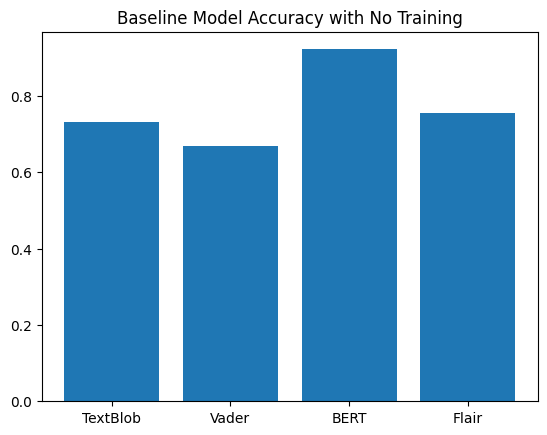

In [48]:
import matplotlib.pyplot as plt

plt.title('Baseline Model Accuracy with No Training')
print(accuracies)
plt.bar(names,accuracies)

[0.732, 0.668, 0.9225, 0.756]